In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import yfinance as yf
from datetime import date
import itertools
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

# Data Preprocessing

In [2]:
# fetch the data
siemen = yf.Ticker("SIE.DE")
siemen

yfinance.Ticker object <SIE.DE>

In [3]:
#Get historical data
sie_data = siemen.history(start ="2015-01-01", end=date.today(), interval="1d")

sie_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-05-31,134.279999,134.679993,132.580002,132.639999,832411,0.0,0
2021-06-01,133.460007,136.419998,133.460007,135.039993,1274211,0.0,0
2021-06-02,134.720001,136.460007,134.419998,136.380005,1173747,0.0,0
2021-06-03,135.940002,136.320007,134.199997,135.759995,941862,0.0,0
2021-06-04,135.779999,136.339996,134.339996,136.000000,930921,0.0,0


### Data Visualization

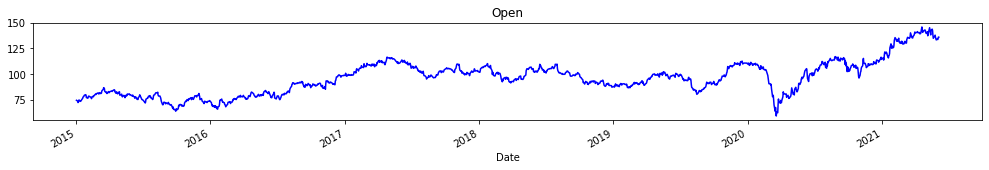

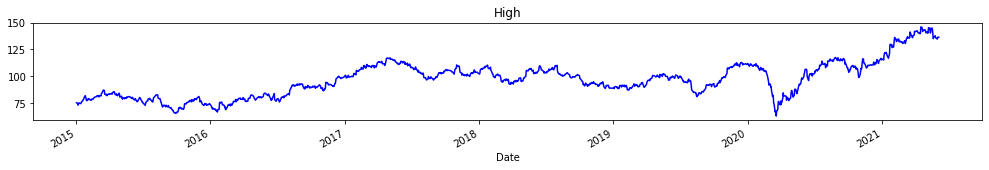

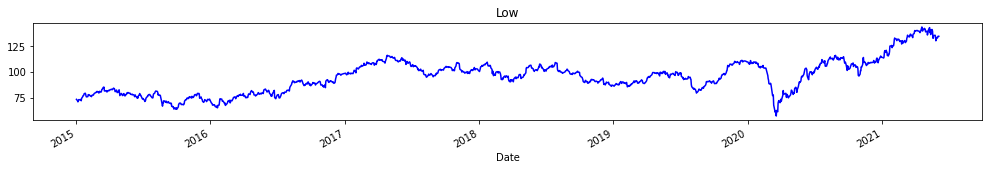

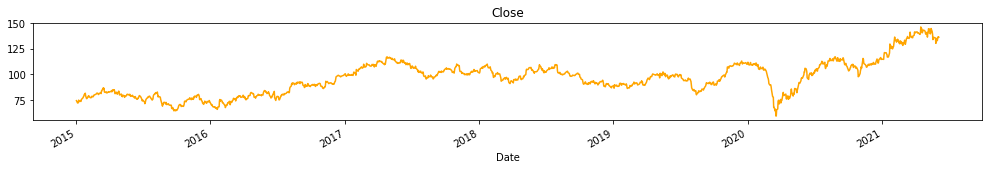

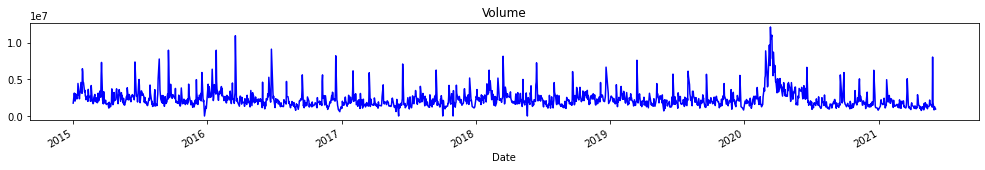

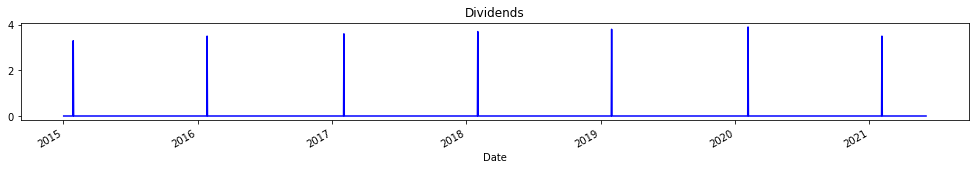

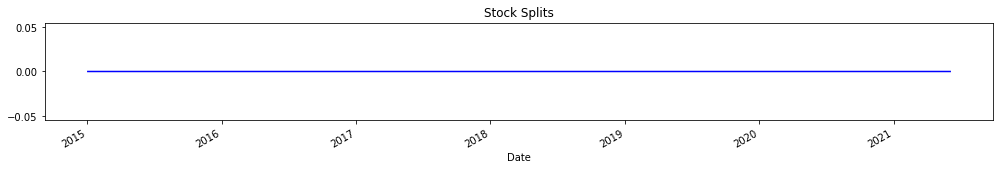

In [4]:
%matplotlib inline

for col in sie_data.columns:
    color="orange" if col == "Close" else "blue"
    sie_data[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [5]:
# Reset the index, change Date to column
sie_data = sie_data.reset_index()
sie_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-01-02,74.446556,75.230536,73.385406,74.248581,1758856,0.0,0
1,2015-01-05,73.828881,74.779159,71.983751,72.007507,3126357,0.0,0
2,2015-01-06,72.308426,73.076571,70.978033,71.944153,2718101,0.0,0
3,2015-01-07,72.379694,73.116162,71.809525,72.403450,2032739,0.0,0
4,2015-01-08,73.567554,74.834594,73.092415,74.771240,3039053,0.0,0


In [6]:
#check if date is in datetime format
sie_data.Date.dtype

dtype('<M8[ns]')

### Changing the Column names
Facebook prophet takes only two features(columns). The column names must be ds: date, s:close. We are going to rename our columns.

In [7]:
#Extracting the date and close price columns
sie_df = sie_data[["Date", "Close"]]
sie_df.head()

,Date,Close
0,2015-01-02,74.248581
1,2015-01-05,72.007507
2,2015-01-06,71.944153
3,2015-01-07,72.403450
4,2015-01-08,74.771240


In [8]:
#rename the columns
sie_df = sie_df.rename(columns={'Date': 'ds', 'Close': 'y'})
sie_df.head()

,ds,y
0,2015-01-02,74.248581
1,2015-01-05,72.007507
2,2015-01-06,71.944153
3,2015-01-07,72.403450
4,2015-01-08,74.771240


### Splitting the Data

In [11]:
index = int(0.8 * sie_df.shape[0])
train_df = sie_df[:index]
test_df = sie_df[index:]

In [12]:
print(train_df.shape)
print(test_df.shape)

(1302, 2)
(326, 2)


### Hyperparameter Tuning

In [13]:
cutoffs = pd.to_datetime(["2016-01-09", "2016-07-09", "2017-01-09"])

In [14]:
# import itertools
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.diagnostics import cross_validation
# from fbprophet.plot import plot_cross_validation_metric
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(train_df)  # Fit model with given params
#     df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
#     cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
#     cutoff = df_cv['cutoff'].unique()[0]
#     df_cv = df_cv[df_cv['cutoff'].values == cutoff]

#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

## Fitting the Model

In [15]:
model = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True,yearly_seasonality=True, interval_width = 0.95)
model.add_seasonality('self_define_cycle',period=8,fourier_order=8,mode='additive')
model.fit(train_df)

## Make Future Prediction
👇Before predicting future values with Facebook's Prophet library, you first need to create a placeholder dataframe that will eventually hold the predictions. Once you create the dataframe, try to predict 2 years in the future.

You can create the predictions' dataframe using `make_future_dataframe()`

In [16]:
horizon = 36
future = model.make_future_dataframe(periods =horizon, freq="M")
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1333,2022-09-30,157.545319,-398.265340,725.917544
1334,2022-10-31,163.677948,-428.662114,743.784901
1335,2022-11-30,169.323137,-453.160930,760.009397
1336,2022-12-31,171.413140,-474.514710,792.349821
1337,2023-01-31,174.639194,-495.323153,837.224488


## Plotting the Forecast

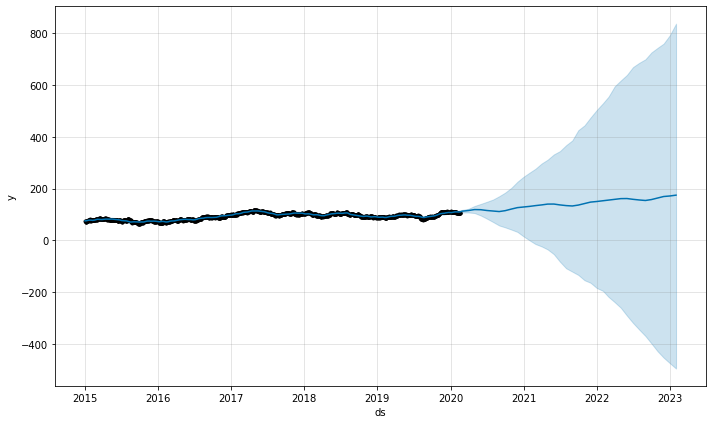

In [17]:
ax = model.plot(forecast);

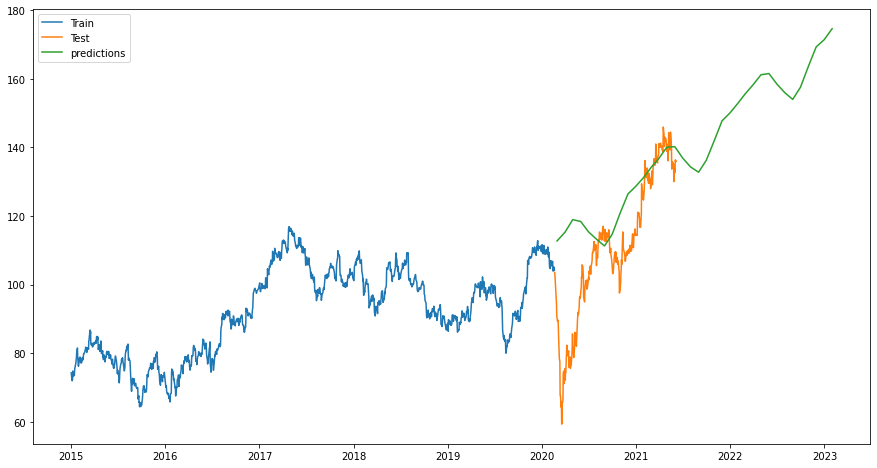

In [18]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

The Train data is from 2015-the beginning of 2020, while the test data is from the beginning of 2020 to middle of 2021 and our forecasted data started predicting from 2020 to 2023

## Time Series' trend and seasonality

👇 Plot the trend and yearly seasonality of the time series. This can be done using the `plot_components()` function from Facebook's Prophet Library

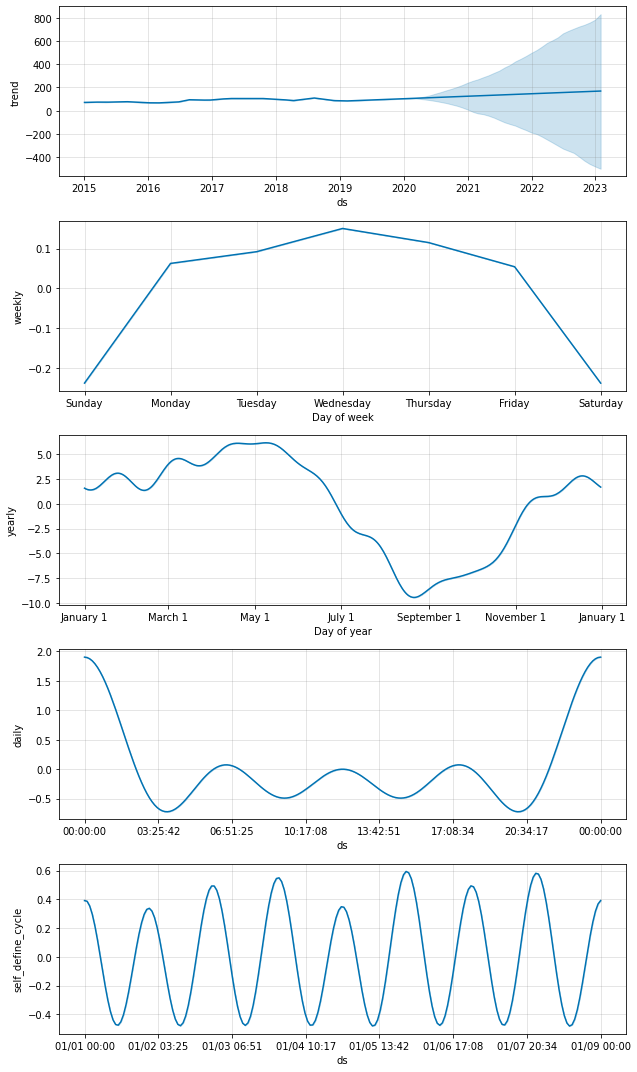

In [19]:
model.plot_components(forecast);

## Evaluating the model with cross-validation!
👇 Using cross_validation() and performance_metrics() from fbprophet.diagnostics, evaluate the performance of your model

More precisely, create a Time Series K-fold CV with

* train sets of size 5 years
* horizon val sizes of 1 years
* shifting each fold by 180 days


In [22]:
# Your code here
cv_results = cross_validation(model=model, initial=f'{365 * 3} days', horizon='365 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-02-24 00:00:00 and 2019-02-19 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
cv_results.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
748,2020-02-13,90.275726,-83.335577,265.144586,104.402206,2019-02-19
749,2020-02-14,90.260177,-82.256419,264.201420,103.915077,2019-02-19
750,2020-02-17,90.389359,-83.810438,267.637918,105.103668,2019-02-19
751,2020-02-18,90.602417,-87.311615,269.731244,104.090431,2019-02-19
752,2020-02-19,90.745678,-88.296223,270.087572,104.129410,2019-02-19


In [24]:
#performance metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,22.879792,4.783283,3.689283,0.039063,0.027339,0.706667
1,37 days,23.155687,4.812036,3.742390,0.039659,0.027596,0.706667
2,38 days,24.084299,4.907576,3.847529,0.040829,0.033496,0.693333
3,39 days,24.981514,4.998151,3.931247,0.041767,0.033496,0.680000
4,40 days,25.301551,5.030065,3.990000,0.042401,0.033715,0.693333


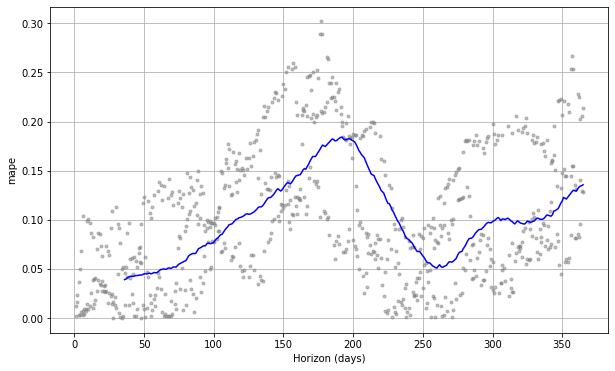

In [25]:
plot_cross_validation_metric(cv_results, metric='mape');

## Tuning our model

In [34]:
m = Prophet(
    growth="linear",
    seasonality_mode="additive",
    changepoint_prior_scale =30,
    seasonality_prior_scale=35,
    holidays_prior_scale = 20,
    daily_seasonality = False,
    weekly_seasonality = False,
    yearly_seasonality = False,).add_seasonality(
    name="monthly",
    period =30.5,
    fourier_order = 55).add_seasonality(
    name="daily",
    period =1,
    fourier_order = 15).add_seasonality(
    name="weekly",
    period = 7,
    fourier_order = 20).add_seasonality(
    name="yearly",
    period =365.25,
    fourier_order = 20).add_seasonality(
    name="quarterly",
    period =365.25/4,
    fourier_order = 15,
    prior_scale = 15)

In [37]:
m.fit(train_df)

In [38]:
import json
from fbprophet.serialize import model_to_json, model_from_json
with open('serialized_model.json', 'w') as my_model:
    json.dump(model_to_json(m), my_model)

In [31]:
horizon = 36
future = m.make_future_dataframe(periods =horizon, freq="M")
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1333,2022-09-30,153.666542,-563.318633,868.631607
1334,2022-10-31,161.777173,-591.972197,908.289302
1335,2022-11-30,170.303655,-598.831485,959.093026
1336,2022-12-31,172.075050,-639.523627,992.585970
1337,2023-01-31,172.287400,-681.267327,1047.862644


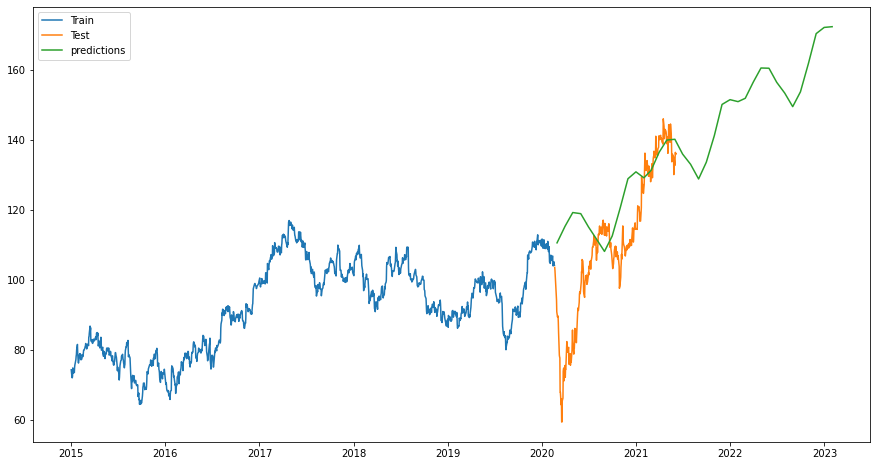

In [33]:
#Plotting the train, test and forecast for comparison
plt.figure(figsize=(15, 8))
plt.plot(train_df['ds'], train_df['y'], label="Train")
plt.plot(test_df['ds'], test_df['y'], label="Test")
plt.plot(forecast2[-horizon:]['ds'], forecast2[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()